# Electrophysiology analysis
This notebook will walk through the basic analysis of LFP and spike data during the virtual foraging task. It uses data that has already been preprocessed in the `ephys_preprocessing` notebook.

## Initial setup

### Imports

In [1]:
# General
import os
import sys
import json
import struct
from time import time
import tempfile
import getpass

# Analysis
import numpy as np
import math

# Visualization
import matplotlib
import matplotlib.pyplot as plt

# Code
sys.path.insert(0, '../python/')
from session import Session, FreeSession
import util

/home/james/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import importlib
import util
importlib.reload(util)


<module 'util' from '../python/util.py'>

### Settings

In [15]:
### Directories ###
# Behavior data
#labview_filepath = 'Y:/James/data/Ephys/02-04-19/labview/j6z4_d25_2019_02_04_16_29_34.mat'
labview_filepath = '/media/james/mcginley_server_3/James/data/Ephys/02-04-19/labview/j6z4_d25_2019_02_04_16_29_34.mat'
sess_filepath = None

# Raw ephys data
#raw_dir = 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928/'
raw_dir = '/media/james/mcginley_server_3/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928/'

# Preprocessed ephys data (Google Drive API)
pre_dir = '/media/james/data/foraging/ephys/02-04-19/spike_sorting/mountainsort/shank_1/' # preprocessed data directory
timeseries_filepath = pre_dir + 'original/raw_w.mda'
firings_filepath = pre_dir + 'curation_1/firings_final.mda'
cluster_metrics_filepath = pre_dir + 'curation_1/metrics_curated_tagged.json'

# Other ephys data
timestamps_filepath = '/media/james/data/foraging/ephys/02-04-19/general/timestamps_daq_clock.npy'
use_google_drive = False # if true, find files in Google Drive
storage_mode = 1 # 0 = read from server, 1 = download to local disk, 2 = load in memory

results_dir = '/media/james/data/foraging/ephys/02-04-19/analysis/shank_1/' # directory to store downloads

In [ ]:
# Allow read/write permissions from directory
password = getpass.getpass()
command = 'sudo -S chmod 777 %s' % results_dir # -S enables input from stdin
os.system('echo %s | %s' % (password, command));

### Load behavior data

In [16]:
sess = FreeSession(labview_filepath)
if sess_filepath is not None:
    sess.load(sess_filepath)

## Spike analysis

### Load spike data

In [17]:
# Load data
if use_google_drive:
    # Create Service object
    drive_service = util.GoogleDriveService()
    
    # Load spike data
    print('Loading spike data...', end=' ')
    firings = util.bytes_to_object(drive_service.download(filename=firings_filepath), ob_type='numpy')
    print('done.')
    
    # Load Intan timestamps
    print('Loading Intan timestamps...', end=' ')
    t_intan = util.bytes_to_object(drive_service.download(filename=timestamps_filepath), ob_type='numpy')
    t_firings = t_intan[firings[1, :].astype(np.int32)]
    print('done.')
    
    # Load File object for reading timeseries MDA file
    print('Creating File object for timeseries MDA file...', end=' ')
    if storage_mode == 0:
        # To save storage, can continually read from server, but this can be prohibitively slow
        # if many reads are required
        drive_file = util.GoogleDriveFile(drive_service, timeseries_filepath)
        timeseries_reader = util.MDAReader(drive_file)
    elif storage_mode == 1:
        # Faster to download entire file and store on hard disk, but files can be large (~50+ GB)
        if not os.path.exists(media_dir + timeseries_filepath):
            f = open(media_dir + timeseries_filepath, 'w+b')
            drive_service.download(filename=timeseries_filepath, file_object=f)
            f.seek(0, 0) # reset pointer to beginning of file
        else:
            f = open(media_dir + timeseries_filepath, 'rb')
        timeseries_reader = util.MDAReader(f)
    elif storage_mode == 2:
        # Fastest to load entirely in memory
        f = io.BytesIO(drive_service.download(filename=timeseries_filepath))
        timeseries_reader = util.MDAReader(f)
    else:
        raise SyntaxError('Unknown storage mode %d.' % storage_mode)
    print('done.')
        
    # Load cluster metrics
    cluster_metrics = util.bytes_to_object(drive_service.download(filename=cluster_metrics_filepath), ob_type='json')
    
else:
    # Load spike data
    print('Loading spike data...', end=' ')
    with open(firings_filepath, 'rb') as f:
        firings = util.MDAReader(f).read()
    print('done.')
    
    # Load Intan timestamps
    print('Loading Intan timestamps...', end=' ')
    t_intan = np.load(timestamps_filepath)
    t_firings = t_intan[firings[1, :].astype(np.int32)]
    print('done.')
    
    # Load File object for reading timeseries MDA file
    print('Creating File object for timeseries MDA file...', end=' ')
    if storage_mode in [0, 1]:
        timeseries_reader = util.MDAReader(open(timeseries_filepath, 'rb'))
    elif storage_mode == 2:
        timeseries_reader = io.BytesIO(open(timeseries_filepath, 'rb'))
    print('done.')
    
    # Load cluster metrics
    print('Loading cluster metrics...', end=' ')
    with open(cluster_metrics_filepath, 'r') as f:
        cluster_metrics = json.loads(f.read())
    print('done.')

Loading spike data... done.
Loading Intan timestamps... done.
Creating File object for timeseries MDA file... done.
Loading cluster metrics... done.


In [22]:
# Limit to active behavior
# t_intan[t] = -1 for all t not during active behavior
firings = firings[:, t_firings > 0.0]
t_firings = t_firings[t_firings > 0.0]

# Get cluster labels
cluster_labels = np.unique(firings[2, :]).astype(np.int32)

### Plot spike raster across session

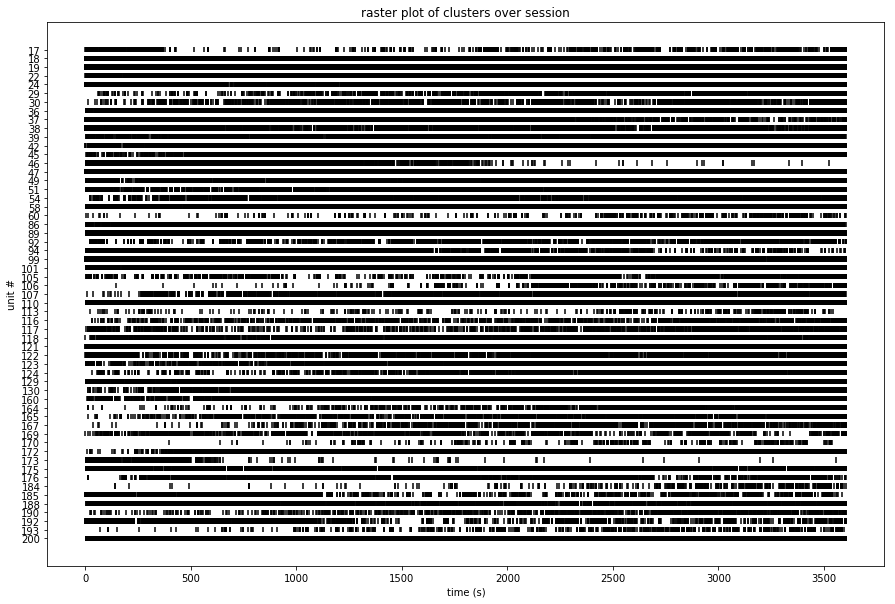

In [23]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 10))

# Raster plot
for i, label in enumerate(cluster_labels):
    ax.vlines(t_firings[firings[2, :] == label], ymin=-(i-0.3), ymax=-(i+0.3))

# Plot settings
ax.set_yticks(-np.arange(len(cluster_labels)))
ax.set_yticklabels(cluster_labels)
ax.set_xlabel('time (s)')
ax.set_ylabel('unit #')
ax.set_title('raster plot of clusters over session');

### Create smoothing kernel

In [25]:
def convolve(x, k, axis=0):
    if axis < 0:
        axis = x.ndim + axis
    a = axis
    b = x.ndim - axis - 1
    x_smooth = np.zeros(x.shape)
    for i in range(x.shape[axis]):
        slc = [slice(None)]*a + [i] + [slice(None)]*b
        idx = np.arange(x.shape[axis]) - i # zero-center mean
        k_i = k(idx)[[np.newaxis]*a + [slice(None)] + [np.newaxis]*b]
        x_smooth[slc] = np.sum(k_i * x, axis=axis)
    
    return x_smooth

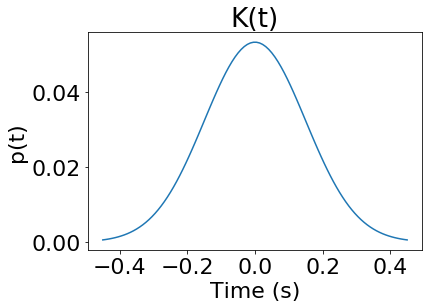

In [152]:
# Create kernel
sigma_k = 0.150 / dt_bin # kernel width (ms)
kernel = lambda x: 1/(2*math.pi*sigma_k**2)**0.5 * np.exp(-0.5 * x**2 / sigma_k**2)

# Plot kernel over +/- 3 standard deviations
x = np.linspace(-3*sigma_k, 3*sigma_k, num=100)
fig, ax = plt.subplots()
ax.plot(x*dt_bin, kernel(x))
ax.set_title('K(t)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('p(t)');

### Peri-leaving activity

#### Settings

In [153]:
window = [-10.0, 10.0] # window around leaving decision
dt_bin = 0.020 # bin size (s)
min_dt_patch = abs(window[0])

#### Get firing rates

In [154]:
# Get leaving times
print('Getting patch times...', end=' ')
t_patch = sess.get_patch_times()
dt_patch = sess.get_patch_durations()
t_leave = t_patch[:, 1]
t_leave = t_leave[dt_patch > min_dt_patch]
print('done.')
print('Found %d analyzable leaving times.' % len(t_leave))

# Create time bins within patch-leaving window
bins = np.arange(window[0]/dt_bin, window[1]/dt_bin + dt_bin) * dt_bin
t_bins = t_leave[:, np.newaxis] + bins[np.newaxis, :]

# Placeholder
f_bin = np.zeros([len(cluster_labels), len(t_leave), len(bins)-1])

# Iterate through units
for i, label in enumerate(cluster_labels):
    print('Processing unit %d (%d of %d)...' % (label, i+1, len(cluster_labels)), end=' ')
    t = time()
    
    # Get spike times
    t_firings_ = t_firings[firings[2, :] == label]
    
    # Determine number of spikes in bins over all leaving windows
    in_bin = np.logical_and((t_firings_[np.newaxis, np.newaxis, :] >= t_bins[:, :-1, np.newaxis]), 
                            (t_firings_[np.newaxis, np.newaxis, :] <  t_bins[:, 1:, np.newaxis]))
    n_unit = np.sum(in_bin.astype(np.int32), axis=-1) # sum over spikes
    
    # Discretized firing rate
    f_bin[i, :, :] = n_unit / dt_bin
    
    print('done. (%.3f seconds)' % (time() - t))

# Save discrete firing rates (allow for different smoothing)
print('Saving firings rates...', end=' ')
d = {'f_bin': f_bin,
     'bins': bins,
     'labels': cluster_labels}
np.save(results_dir + 'firing_rates_leave.npy', d)
print('done.')

# Smoothed firing rate
f_smooth = convolve(f_bin, kernel, axis=-1)
f_smooth_mean = np.mean(f_smooth, axis=1) # take mean over trials
f_smooth_std = np.std(f_smooth, axis=1) # important to take std of smoothed, not binned, values

Getting patch times... done.
Found 45 analyzable leaving times.
Processing unit 17 (1 of 57)... done. (0.495 seconds)
Processing unit 18 (2 of 57)... done. (5.856 seconds)
Processing unit 19 (3 of 57)... done. (4.440 seconds)
Processing unit 22 (4 of 57)... done. (2.906 seconds)
Processing unit 24 (5 of 57)... done. (2.723 seconds)
Processing unit 29 (6 of 57)... done. (1.010 seconds)
Processing unit 30 (7 of 57)... done. (0.684 seconds)
Processing unit 36 (8 of 57)... done. (3.754 seconds)
Processing unit 37 (9 of 57)... done. (1.622 seconds)
Processing unit 38 (10 of 57)... done. (2.053 seconds)
Processing unit 39 (11 of 57)... done. (1.419 seconds)
Processing unit 42 (12 of 57)... done. (4.804 seconds)
Processing unit 45 (13 of 57)... done. (1.755 seconds)
Processing unit 46 (14 of 57)... done. (1.484 seconds)
Processing unit 47 (15 of 57)... done. (6.147 seconds)
Processing unit 49 (16 of 57)... done. (1.644 seconds)
Processing unit 51 (17 of 57)... done. (1.928 seconds)
Processing

In [157]:
matplotlib.rcParams.update({'font.size': 12})

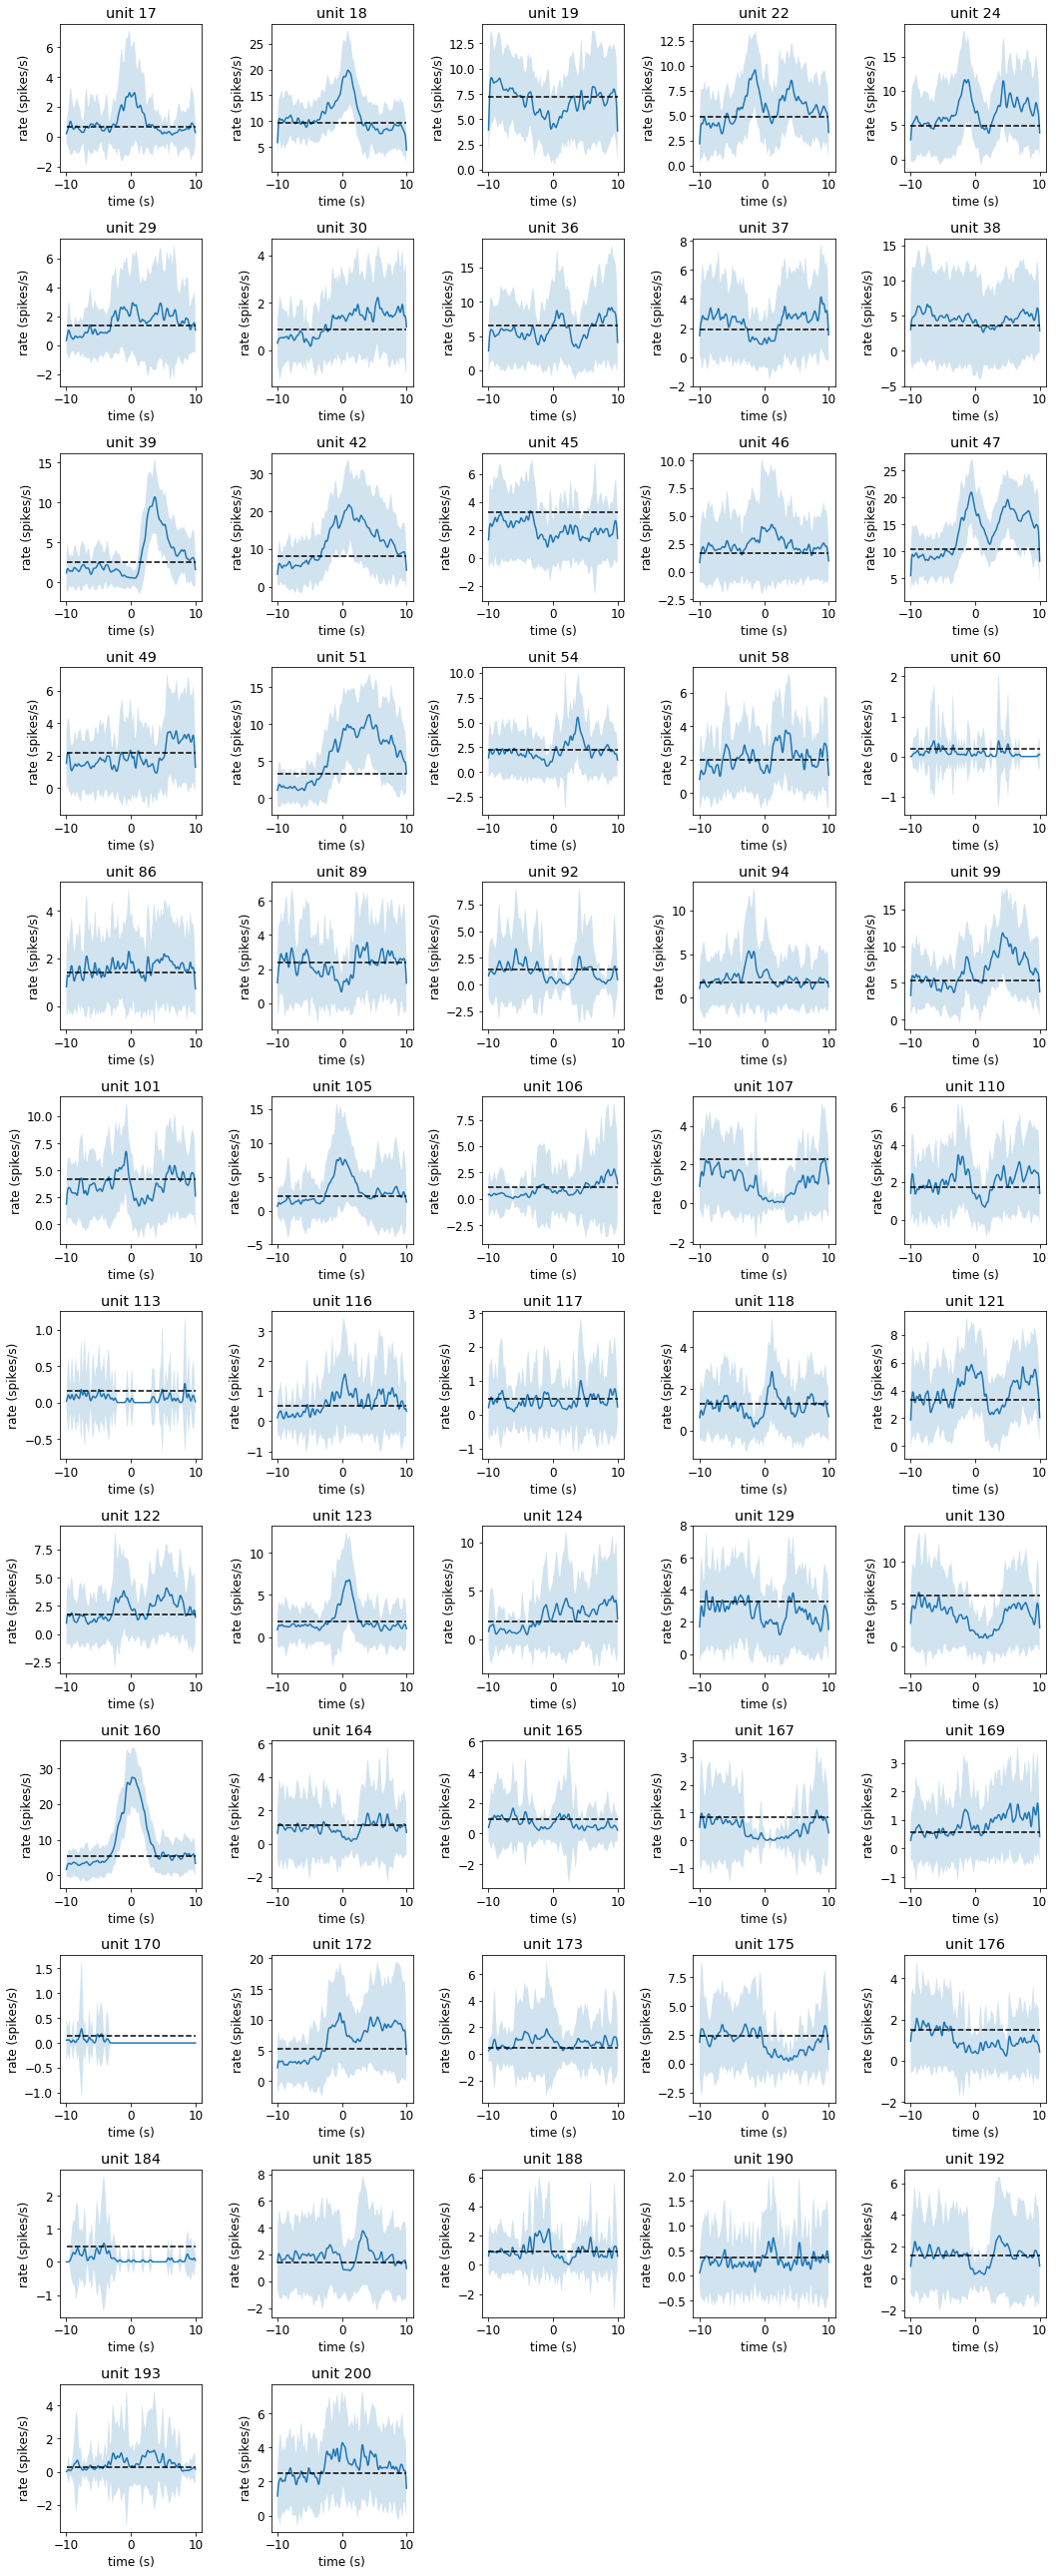

In [158]:
# Place label order of metrics file in array for easy indexing
metrics_labels = np.zeros(len(cluster_metrics['clusters']), dtype=np.int32)
for i, cluster in enumerate(cluster_metrics['clusters']):
    metrics_labels[i] = cluster['label']

# Plot setup
cols = 5
rows = (len(cluster_labels) // cols) + (len(cluster_labels) % cols > 0)
fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
t = bins[:-1] + 0.5*dt_bin

for i, label in enumerate(cluster_labels):
    #print('Processing label %d (%d of %d)...' % (label, i+1, len(cluster_labels)))
    
    # Idxs
    j = i // cols
    k = i % cols
    l = np.where(metrics_labels == label)[0][0]
    
    # Plot smoothed firing rate within leaving window
    ax[j, k].plot(t, f_smooth_mean[i, :])
    #err = f_smooth_std[i, :]/f_smooth.shape[1]**0.5 # sem
    err = f_smooth_std[i, :] # std
    ax[j, k].fill_between(t, 
                          y1=f_smooth_mean[i, :]-err, 
                          y2=f_smooth_mean[i, :]+err,
                          alpha=0.2)
    
    # Plot average firing rate across session
    rate = cluster_metrics['clusters'][l]['metrics']['firing_rate']
    ax[j, k].plot(np.array([t[0], t[-1]]), np.array([rate]*2),
                  linestyle='--', color='black')
    
    # Axis settings
    ax[j, k].set_title('unit %d' % label)
    ax[j, k].set_xlabel('time (s)')
    ax[j, k].set_ylabel('rate (spikes/s)')

# Plot settings
plt.tight_layout()
rem = (cols - len(cluster_labels) % cols) % cols
for i in range(1, rem+1):
    ax[-1, -i].axis('off')
    
# Save figure
plt.savefig(results_dir + 'peri_leaving_activity.pdf')

In [159]:
# Put in std band
# Make nice figures, get story straight
# Pick out examples from above
# center on enter, reward
# discuss automated spike sorting (waveforms)
# Session statistics
dt_patch = sess.get_patch_durations()
dt_ip = sess.get_interpatch_durations()

print('Number of patches: %d' % t_patch.shape[0])
print('Residence times: %.2f +/- %.2f' % (np.mean(dt_patch), np.std(dt_patch)))
print('Travel times: %.2f +/- %.2f' % (np.mean(dt_ip), np.std(dt_ip)))


Number of patches: 52
Residence times: 61.08 +/- 63.87
Travel times: 8.16 +/- 4.29


In [ ]:
# maybe use autocorrelation coefficient to search for non-randomness in curves?

#### Compare velocity
Plot the animal velocity on the same plot as firing rates above. Additionally, compare with stop/go occurences in between patches to see if same peak activity occurs in absence of patch-leaving decision.

### Peri-enter activity

#### Settings

In [160]:
window = [-5.0, 5.0] # window around entering decision
dt_bin = 0.020 # bin size (s)
min_dt_interpatch = abs(window[0])

#### Get firing rates

In [161]:
# Get entering times
print('Getting patch times...', end=' ')
t_patch = sess.get_patch_times()
dt_interpatch = sess.get_interpatch_durations()
t_enter = t_patch[1:, 0]
t_enter = t_enter[dt_interpatch[:-1] > min_dt_interpatch]
print('done.')
print('Found %d analyzable enter times.' % len(t_enter))

# Create time bins within patch-entering window
bins = np.arange(window[0]/dt_bin, window[1]/dt_bin + dt_bin) * dt_bin
t_bins = t_enter[:, np.newaxis] + bins[np.newaxis, :]

# Placeholder
f_bin = np.zeros([len(cluster_labels), len(t_enter), len(bins)-1])

# Iterate through units
for i, label in enumerate(cluster_labels):
    print('Processing unit %d (%d of %d)...' % (label, i+1, len(cluster_labels)), end=' ')
    t = time()
    
    # Get spike times
    t_firings_ = t_firings[firings[2, :] == label]
    
    # Determine number of spikes in bins over all entering windows
    in_bin = np.logical_and((t_firings_[np.newaxis, np.newaxis, :] >= t_bins[:, :-1, np.newaxis]), 
                            (t_firings_[np.newaxis, np.newaxis, :] <  t_bins[:, 1:, np.newaxis]))
    n_unit = np.sum(in_bin.astype(np.int32), axis=-1) # sum over spikes
    
    # Discretized firing rate
    f_bin[i, :, :] = n_unit / dt_bin
    
    print('done. (%.3f seconds)' % (time() - t))


# Save discrete firing rates (allow for different smoothing)
print('Saving firings rates...', end=' ')
d = {'f_bin': f_bin,
     'bins': bins,
     'labels': cluster_labels}
np.save(results_dir + 'firing_rates_enter.npy', d)
print('done.')
    
# Smoothed firing rate
f_smooth = convolve(f_bin, kernel, axis=-1)
f_smooth_mean = np.mean(f_smooth, axis=1) # take mean over trials
f_smooth_std = np.std(f_smooth, axis=1) # important to take std of smoothed, not binned, values

Getting patch times... done.
Found 46 analyzable enter times.
Processing unit 17 (1 of 57)... done. (0.269 seconds)
Processing unit 18 (2 of 57)... done. (3.089 seconds)
Processing unit 19 (3 of 57)... done. (2.314 seconds)
Processing unit 22 (4 of 57)... done. (1.600 seconds)
Processing unit 24 (5 of 57)... done. (1.521 seconds)
Processing unit 29 (6 of 57)... done. (0.568 seconds)
Processing unit 30 (7 of 57)... done. (0.372 seconds)
Processing unit 36 (8 of 57)... done. (1.961 seconds)
Processing unit 37 (9 of 57)... done. (0.937 seconds)
Processing unit 38 (10 of 57)... done. (1.149 seconds)
Processing unit 39 (11 of 57)... done. (0.834 seconds)
Processing unit 42 (12 of 57)... done. (2.708 seconds)
Processing unit 45 (13 of 57)... done. (0.988 seconds)
Processing unit 46 (14 of 57)... done. (0.888 seconds)
Processing unit 47 (15 of 57)... done. (3.289 seconds)
Processing unit 49 (16 of 57)... done. (0.948 seconds)
Processing unit 51 (17 of 57)... done. (1.065 seconds)
Processing u

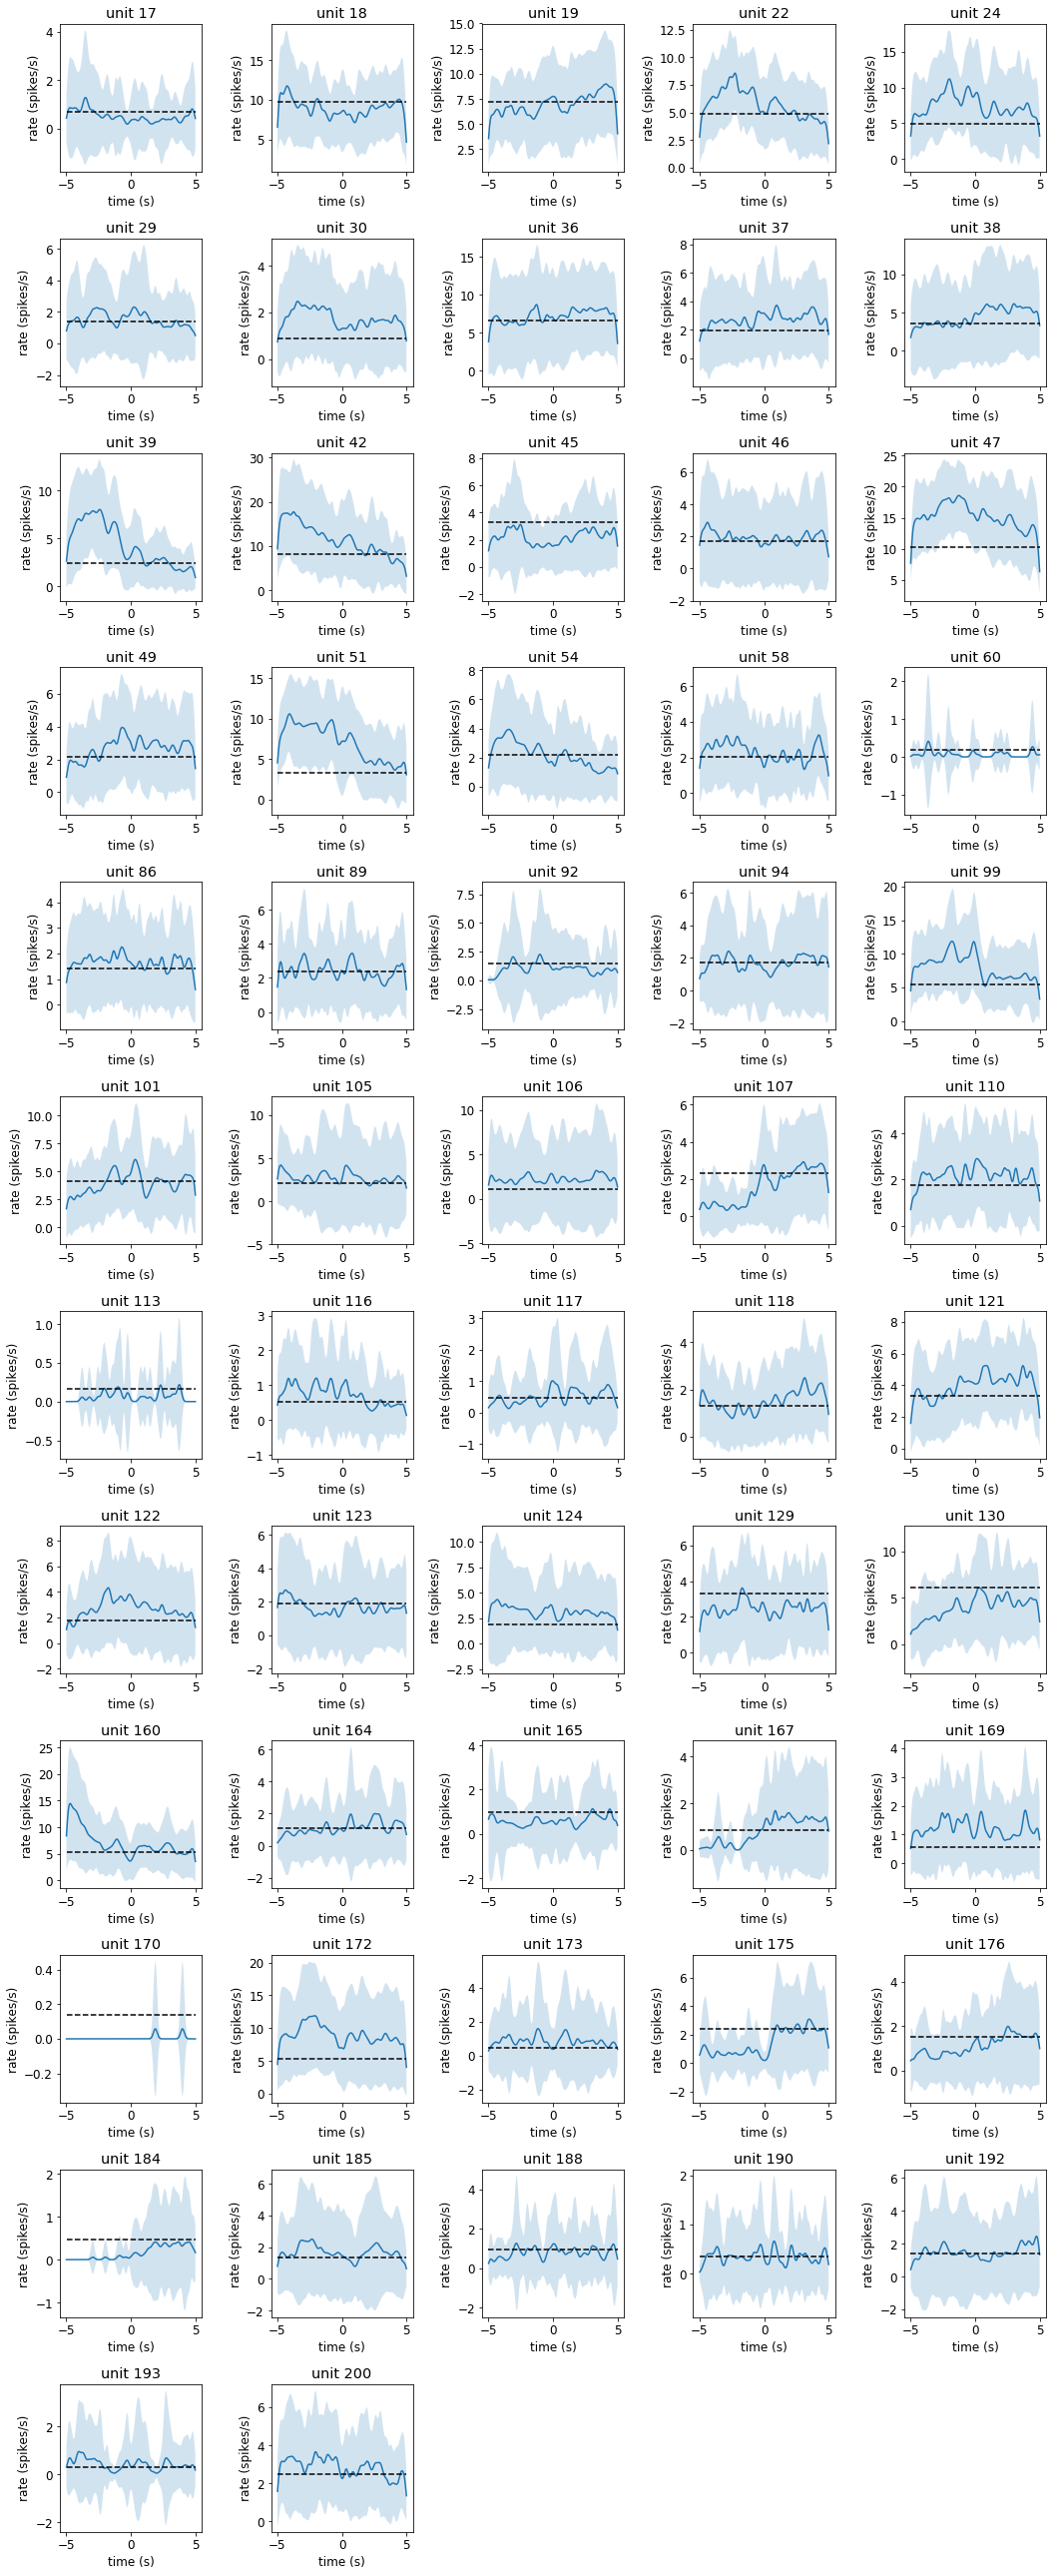

In [162]:
# Place label order of metrics file in array for easy indexing
metrics_labels = np.zeros(len(cluster_metrics['clusters']), dtype=np.int32)
for i, cluster in enumerate(cluster_metrics['clusters']):
    metrics_labels[i] = cluster['label']

# Plot setup
cols = 5
rows = (len(cluster_labels) // cols) + (len(cluster_labels) % cols > 0)
fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
t = bins[:-1] + 0.5*dt_bin

for i, label in enumerate(cluster_labels):
    #print('Processing label %d (%d of %d)...' % (label, i+1, len(cluster_labels)))
    
    # Idxs
    j = i // cols
    k = i % cols
    l = np.where(metrics_labels == label)[0][0]
    
    # Plot smoothed firing rate within entering window
    ax[j, k].plot(t, f_smooth_mean[i, :])
    #err = f_smooth_std[i, :]/f_smooth.shape[1]**0.5 # sem
    err = f_smooth_std[i, :] # std
    ax[j, k].fill_between(t, 
                          y1=f_smooth_mean[i, :]-err, 
                          y2=f_smooth_mean[i, :]+err,
                          alpha=0.2)
    
    # Plot average firing rate across session
    rate = cluster_metrics['clusters'][l]['metrics']['firing_rate']
    ax[j, k].plot(np.array([t[0], t[-1]]), np.array([rate]*2),
                  linestyle='--', color='black')
    
    # Axis settings
    ax[j, k].set_title('unit %d' % label)
    ax[j, k].set_xlabel('time (s)')
    ax[j, k].set_ylabel('rate (spikes/s)')

# Plot settings
plt.tight_layout()
rem = (cols - len(cluster_labels) % cols) % cols
for i in range(1, rem+1):
    ax[-1, -i].axis('off')
    
# Save figure
plt.savefig(results_dir + 'peri_entering_activity.pdf')

### Peri-reward activity

#### Settings

In [163]:
window = [-3.0, 3.0] # window around entering decision
dt_bin = 0.020 # bin size (s)
min_dt_motor = abs(max(window))

#### Get firing rates

In [164]:
# Get reward times
print('Getting reward times...', end=' ')
t_motor = sess.get_motor_times()
idx_keep = np.ones(t_motor.shape, dtype=np.bool)
for i in range(t_motor.shape[0]-1):
    if idx_keep[i] and (t_motor[i+1] - t_motor[i]) < min_dt_motor:
        idx_keep[i+1] = False
t_motor = t_motor[idx_keep]
print('done.')
print('Found %d analyzable reward times.' % len(t_motor))

# Create time bins within patch-leaving window
bins = np.arange(window[0]/dt_bin, window[1]/dt_bin + dt_bin) * dt_bin
t_bins = t_motor[:, np.newaxis] + bins[np.newaxis, :]

# Placeholder
f_bin = np.zeros([len(cluster_labels), len(t_motor), len(bins)-1])

# Iterate through units
for i, label in enumerate(cluster_labels):
    print('Processing unit %d (%d of %d)...' % (label, i+1, len(cluster_labels)), end=' ')
    t = time()
    
    # Get spike times
    t_firings_ = t_firings[firings[2, :] == label]
    
    # Determine number of spikes in bins over all reward windows
    in_bin = np.logical_and((t_firings_[np.newaxis, np.newaxis, :] >= t_bins[:, :-1, np.newaxis]), 
                            (t_firings_[np.newaxis, np.newaxis, :] <  t_bins[:, 1:, np.newaxis]))
    n_unit = np.sum(in_bin.astype(np.int32), axis=-1) # sum over spikes
    
    # Discretized firing rate
    f_bin[i, :, :] = n_unit / dt_bin
    
    print('done. (%.3f seconds)' % (time() - t))

# Save discrete firing rates (allow for different smoothing)
print('Saving firings rates...', end=' ')
d = {'f_bin': f_bin,
     'bins': bins,
     'labels': cluster_labels}
np.save(results_dir + 'firing_rates_reward.npy', d)
print('done.')
    
# Smoothed firing rate
f_smooth = convolve(f_bin, kernel, axis=-1)
f_smooth_mean = np.mean(f_smooth, axis=1) # take mean over trials
f_smooth_std = np.std(f_smooth, axis=1) # important to take std of smoothed, not binned, values

Getting reward times... done.
Found 243 analyzable reward times.
Processing unit 17 (1 of 57)... done. (0.831 seconds)
Processing unit 18 (2 of 57)... done. (9.357 seconds)
Processing unit 19 (3 of 57)... done. (6.989 seconds)
Processing unit 22 (4 of 57)... done. (4.728 seconds)
Processing unit 24 (5 of 57)... done. (4.473 seconds)
Processing unit 29 (6 of 57)... done. (1.692 seconds)
Processing unit 30 (7 of 57)... done. (1.166 seconds)
Processing unit 36 (8 of 57)... done. (5.923 seconds)
Processing unit 37 (9 of 57)... done. (2.663 seconds)
Processing unit 38 (10 of 57)... done. (3.397 seconds)
Processing unit 39 (11 of 57)... done. (2.362 seconds)
Processing unit 42 (12 of 57)... done. (7.711 seconds)
Processing unit 45 (13 of 57)... done. (2.901 seconds)
Processing unit 46 (14 of 57)... done. (2.382 seconds)
Processing unit 47 (15 of 57)... done. (9.921 seconds)
Processing unit 49 (16 of 57)... done. (2.700 seconds)
Processing unit 51 (17 of 57)... done. (3.126 seconds)
Processin

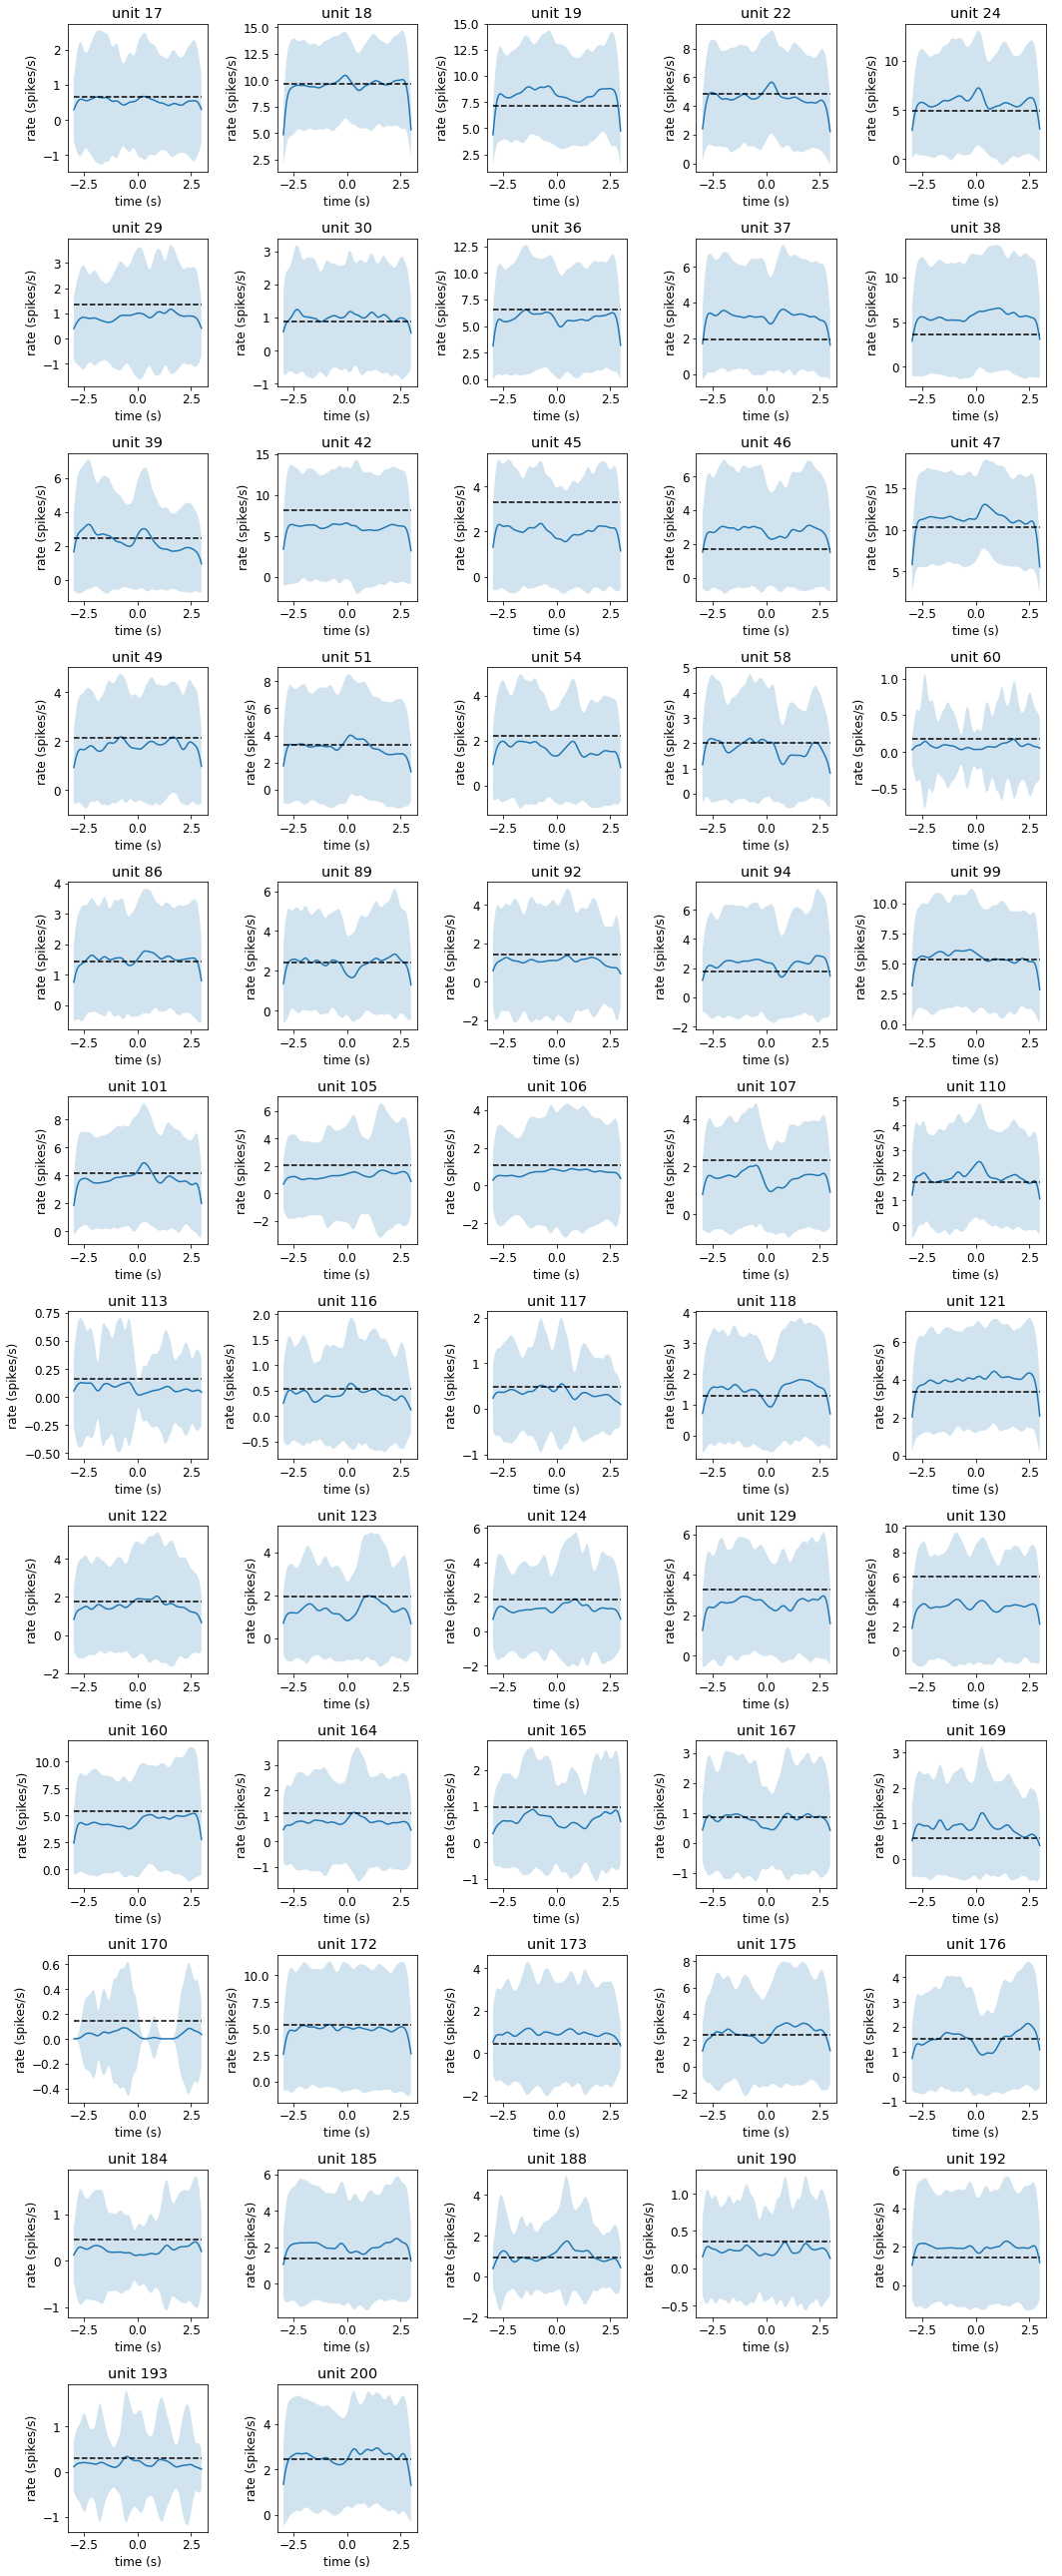

In [165]:
# Place label order of metrics file in array for easy indexing
metrics_labels = np.zeros(len(cluster_metrics['clusters']), dtype=np.int32)
for i, cluster in enumerate(cluster_metrics['clusters']):
    metrics_labels[i] = cluster['label']

# Plot setup
cols = 5
rows = (len(cluster_labels) // cols) + (len(cluster_labels) % cols > 0)
fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
t = bins[:-1] + 0.5*dt_bin

for i, label in enumerate(cluster_labels):
    #print('Processing label %d (%d of %d)...' % (label, i+1, len(cluster_labels)))
    
    # Idxs
    j = i // cols
    k = i % cols
    l = np.where(metrics_labels == label)[0][0]
    
    # Plot smoothed firing rate within reward window
    ax[j, k].plot(t, f_smooth_mean[i, :])
    #err = f_smooth_std[i, :]/f_smooth.shape[1]**0.5 # sem
    err = f_smooth_std[i, :] # std
    ax[j, k].fill_between(t, 
                          y1=f_smooth_mean[i, :]-err, 
                          y2=f_smooth_mean[i, :]+err,
                          alpha=0.2)
    
    # Plot average firing rate across session
    rate = cluster_metrics['clusters'][l]['metrics']['firing_rate']
    ax[j, k].plot(np.array([t[0], t[-1]]), np.array([rate]*2),
                  linestyle='--', color='black')
    
    # Axis settings
    ax[j, k].set_title('unit %d' % label)
    ax[j, k].set_xlabel('time (s)')
    ax[j, k].set_ylabel('rate (spikes/s)')

# Plot settings
plt.tight_layout()
rem = (cols - len(cluster_labels) % cols) % cols
for i in range(1, rem+1):
    ax[-1, -i].axis('off')
    
# Save figure
plt.savefig(results_dir + 'peri_reward_activity.pdf')

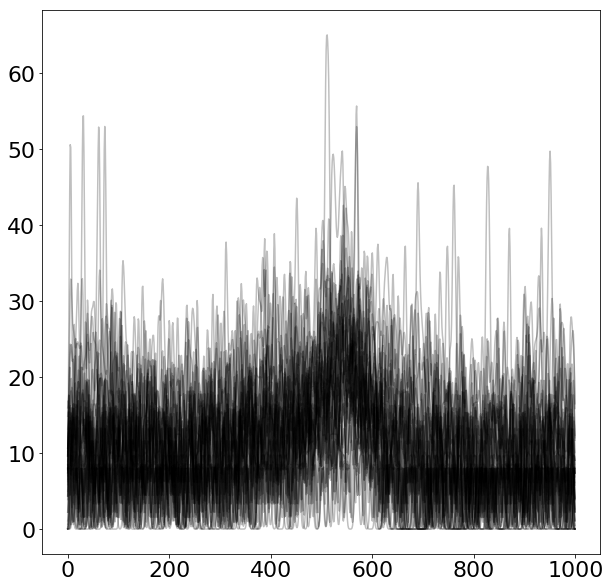

In [151]:
f_bin = data_leave['f_bin']
f_smooth = convolve(f_bin, kernel, axis=-1)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(f_smooth.shape[1]):
    ax.plot(f_smooth[1, i, :], color='black', alpha=0.25)
    
plt.savefig('/home/james/Desktop/traces.eps', dpi=1000)

### Individual unit analysis

#### Settings

In [126]:
import matplotlib

In [166]:
# Select units
labels = np.array([18, 105, 123, 160, 107, 130, 167, 175]) # first four = increased, last four = decreased with patch exit

# matplotlib params
matplotlib.rcParams.update({'font.size': 22})

#### Generate plots

In [167]:
# Place label order of metrics file in array for easy indexing
metrics_labels = np.zeros(len(cluster_metrics['clusters']), dtype=np.int32)
for i, cluster in enumerate(cluster_metrics['clusters']):
    metrics_labels[i] = cluster['label']

# Load data
print('Loading data...', end=' ')
data_leave = np.load(results_dir + 'firing_rates_leave.npy')[()]
data_enter = np.load(results_dir + 'firing_rates_enter.npy')[()]
data_reward = np.load(results_dir + 'firing_rates_reward.npy')[()]
print('done.')

# Placeholder arrays
data_labels = []
t = []
f_smooth_mean = []
f_smooth_std = []
names = ['leave', 'enter', 'reward']

# Create arrays for patch leaving
print('Preprocessing data...', end=' ')
for data in [data_leave, data_enter, data_reward]:
    data_labels.append(data['labels'])
    bins = data['bins']
    dt_bin = bins[1] - bins[0]
    t.append(bins[:-1] + 0.5*dt_bin)
    f_smooth = convolve(data['f_bin'], kernel, axis=-1)
    f_smooth_mean.append(np.mean(f_smooth, axis=1))
    f_smooth_std.append(np.std(f_smooth, axis=1))
print('done.')
    
for i, label in enumerate(labels):
    print('Processing unit %d (%d of %d)...' % (label, i+1, len(labels)), end=' ')
    
    # Set up directory to save plots
    label_dir = results_dir + ('unit_%d/' % label)
    if not os.path.isdir(label_dir):
        os.mkdir(label_dir)
        
    # Find index in cluster metrics and data
    l = np.where(metrics_labels == label)[0][0]
    idx = []
    for data_labels_ in data_labels:
        idx.append(np.where(data_labels_ == label)[0][0])
    
    # Plot and save activity
    it = zip(idx, t, f_smooth_mean, f_smooth_std, names)
    for j, [idx_, t_, f_, f_std_, name_] in enumerate(it):    
        # Create new figure
        fig, ax = plt.subplots(figsize=(15, 15))
        
        # Plot smoothed firing rate within window
        ax.plot(t_, f_[idx_, :])
        err = f_std_[idx_, :] # std
        ax.fill_between(t_, 
                        y1=f_[idx_, :]-err, 
                        y2=f_[idx_, :]+err,
                        alpha=0.2)

        # Plot average firing rate across session
        rate = cluster_metrics['clusters'][l]['metrics']['firing_rate']
        ax.plot(np.array([t_[0], t_[-1]]), np.array([rate]*2),
                linestyle='--', color='black')

        # Axis settings
        ax.set_title('unit %d' % label)
        ax.set_xlabel('time (s)')
        ax.set_ylabel('rate (spikes/s)')
        ylim = ax.get_ylim()
        ax.set_ylim([-0.05*abs(ylim[1]), ylim[1]])
        
        # Save figure
        plt.savefig(label_dir + 'peri_%s_activity.pdf' % name_)
        
        plt.close()
    
    print('done.')

Loading data... done.
Preprocessing data... done.
Processing unit 18 (1 of 8)... done.
Processing unit 105 (2 of 8)... done.
Processing unit 123 (3 of 8)... done.
Processing unit 160 (4 of 8)... done.
Processing unit 107 (5 of 8)... done.
Processing unit 130 (6 of 8)... done.
Processing unit 167 (7 of 8)... done.
Processing unit 175 (8 of 8)... done.


## LFP analysis

In [247]:
f = open(timeseries_filepath, 'rb')
header_length = 0

# First 32 bits = signed integer indicating data type
code, = struct.unpack('i', f.read(4))
header_length += 4

# Second 32 bits: number of bytes per entry
entry_size, = struct.unpack('i', f.read(4))
header_length += 4

# Third 32 bits: number of dimensions
n_dims, = struct.unpack('i', f.read(4))
header_length += 4

# Next 32*n_dims bits: size of each dimension
shape = np.zeros(n_dims, dtype=np.int64)
for i in range(n_dims):
    shape[i], = struct.unpack('i', f.read(4))
    header_length += 4
print('Number of channels: %d' % shape[0])
print('Number of data points: %d' % shape[1])

# Determine data type from code
if code == -3: # float32
    n_bytes = 4
    format_char = 'f'
elif code == -4: # int16
    n_bytes = 2
    format_char = 'h'
elif code == -5: # int32
    n_bytes = 4
    format_char = 'i'
elif code == -6: # uint16
    n_bytes = 2
    format_char = 'H'
elif code == -7: # double
    n_bytes = 8
    format_char = 'd'
elif code == -8: # uint32
    n_bytes = 4
    format_char = 'I'
else:
    raise ValueError('Unknown code (%d).' % code)

Number of channels: 64
Number of data points: 116875200
